In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "../../" not in sys.path:
    sys.path.append("../../")
    print("[sys.path]:", sys.path)

[sys.path]: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages', '../../']


In [3]:
from src.data.babel import BabelDataset

/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dataset = BabelDataset(
    split="train",
    pipeline="babel-proc-label"
)
validation_dataset = BabelDataset(
    split="validation",
    pipeline="babel-proc-label"
)

Repo card metadata block was not found. Setting CardData to empty.
Map (num_proc=8): 100%|██████████| 6615/6615 [00:55<00:00, 119.74 examples/s]
Repo card metadata block was not found. Setting CardData to empty.
Map (num_proc=8): 100%|██████████| 2193/2193 [00:24<00:00, 88.93 examples/s] 


In [5]:
print("[#train_dataset]:", len(train_dataset))
print("[#validation_dataset]:", len(validation_dataset))

[#train_dataset]: 6615
[#validation_dataset]: 2193


In [6]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [7]:
plt.style.use('default')
sns.set_palette("husl")

In [8]:
def analyze_prompts(dataset, dataset_name="Dataset"):
    all_prompts = []
    sample_prompt_counts = []
    source_counts = Counter()
    is_sequence_counts = Counter()
    durations = []
    sequence_durations = []
    frame_durations = []
    spans_per_prompt = defaultdict(list)
    
    motion_lengths_frames = []
    motion_lengths_seconds = []
    spans_per_motion = []
    spans_durations_per_motion = []
    
    for i, sample in enumerate(tqdm.tqdm(dataset)):
        prompts_list = sample.get("prompts", [])
        sample_prompt_counts.append(len(prompts_list))
        
        motion = sample.get("motion", {})
        if isinstance(motion, dict) and "new_joint_vecs" in motion:
            motion_length = len(motion["new_joint_vecs"])
            motion_lengths_frames.append(motion_length)
            motion_lengths_seconds.append(motion_length / DEFAULT_FPS)
        
        motion_spans = []
        motion_spans_durations = []
        
        for prompt_data in prompts_list:
            prompt_text = prompt_data.get("text", "")
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            is_sequence = prompt_data.get("is_sequence", True)
            
            all_prompts.append(prompt_text)
            source_counts[source] += 1
            is_sequence_counts[is_sequence] += 1
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                durations.append(duration_frames)
                spans_per_prompt[prompt_text].append(span)
                motion_spans.append(span)
                motion_spans_durations.append(duration_frames)
                
                if is_sequence:
                    sequence_durations.append(duration_frames)
                else:
                    frame_durations.append(duration_frames)
        
        spans_per_motion.append(len(motion_spans))
        spans_durations_per_motion.append(sum(motion_spans_durations) if motion_spans_durations else 0)
    
    return {
        'all_prompts': all_prompts,
        'sample_prompt_counts': sample_prompt_counts,
        'source_counts': source_counts,
        'is_sequence_counts': is_sequence_counts,
        'durations': durations,
        'sequence_durations': sequence_durations,
        'frame_durations': frame_durations,
        'spans_per_prompt': spans_per_prompt,
        'dataset_name': dataset_name,
        'motion_lengths_frames': motion_lengths_frames,
        'motion_lengths_seconds': motion_lengths_seconds,
        'spans_per_motion': spans_per_motion,
        'spans_durations_per_motion': spans_durations_per_motion
    }

In [9]:
train_analysis = analyze_prompts(train_dataset, "Train")
validation_analysis = analyze_prompts(validation_dataset, "Validation")

  0%|          | 0/6615 [00:00<?, ?it/s]

100%|██████████| 2193/2193 [02:09<00:00, 16.89it/s]


In [10]:
print("=== BASIC STATISTICS ===")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(validation_dataset)} samples")
print()

for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
Train Dataset: 6615 samples
Validation Dataset: 2193 samples

Train Dataset:
  Total prompts: 43119
  Unique prompts: 6093
  Avg prompts per sample: 6.52
  Min prompts per sample: 1
  Max prompts per sample: 89

  Source distribution:
    proc_label: 43119 (100.0%)

  Sequence vs Frame annotations:
    Sequence: 7000 (16.2%)
    Frame: 36119 (83.8%)

  Duration statistics (frames):
    Min: 0 frames (0.00s)
    Mean: 73.47 frames (3.67s)
    Max: 5271 frames (263.55s)
    Std: 171.31 frames (8.57s)
--------------------------------------------------
Validation Dataset:
  Total prompts: 15740
  Unique prompts: 2844
  Avg prompts per sample: 7.18
  Min prompts per sample: 1
  Max prompts per sample: 84

  Source distribution:
    proc_label: 15740 (100.0%)

  Sequence vs Frame annotations:
    Sequence: 2411 (15.3%)
    Frame: 13329 (84.7%)

  Duration statistics (frames):
    Min: 0 frames (0.00s)
    Mean: 81.31 frames (4.07s)
    Max: 4158 frames (207.90s)
    

<div class="alert alert-info">

#### **Number of Motions**

This shows the total number of motion sequences in each dataset split.

</div>

=== NUMBER OF MOTIONS ===
Train Dataset: 6615 motions
Validation Dataset: 2193 motions


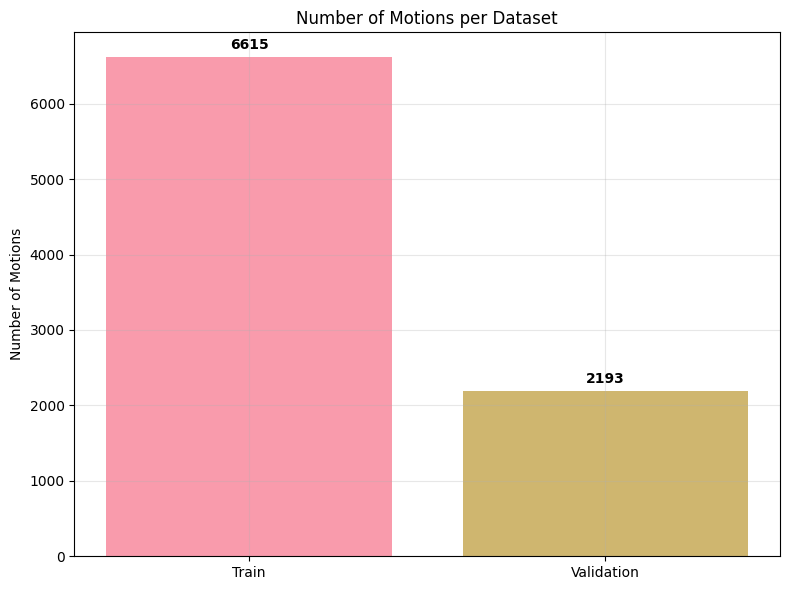

In [11]:
print("=== NUMBER OF MOTIONS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    num_motions = len(analysis['motion_lengths_frames'])
    print(f"{name} Dataset: {num_motions} motions")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
datasets = ['Train', 'Validation']
motion_counts = [len(train_analysis['motion_lengths_frames']), len(validation_analysis['motion_lengths_frames'])]
colors = ['C0', 'C1']

bars = ax.bar(datasets, motion_counts, color=colors, alpha=0.7)
ax.set_title('Number of Motions per Dataset')
ax.set_ylabel('Number of Motions')
ax.grid(True, alpha=0.3)

for bar, count in zip(bars, motion_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(motion_counts)*0.01, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Motion Length Distribution**

This shows the distribution of motion sequence lengths in both frames and seconds, with horizontal lines indicating minimum, maximum, and average values.

</div>

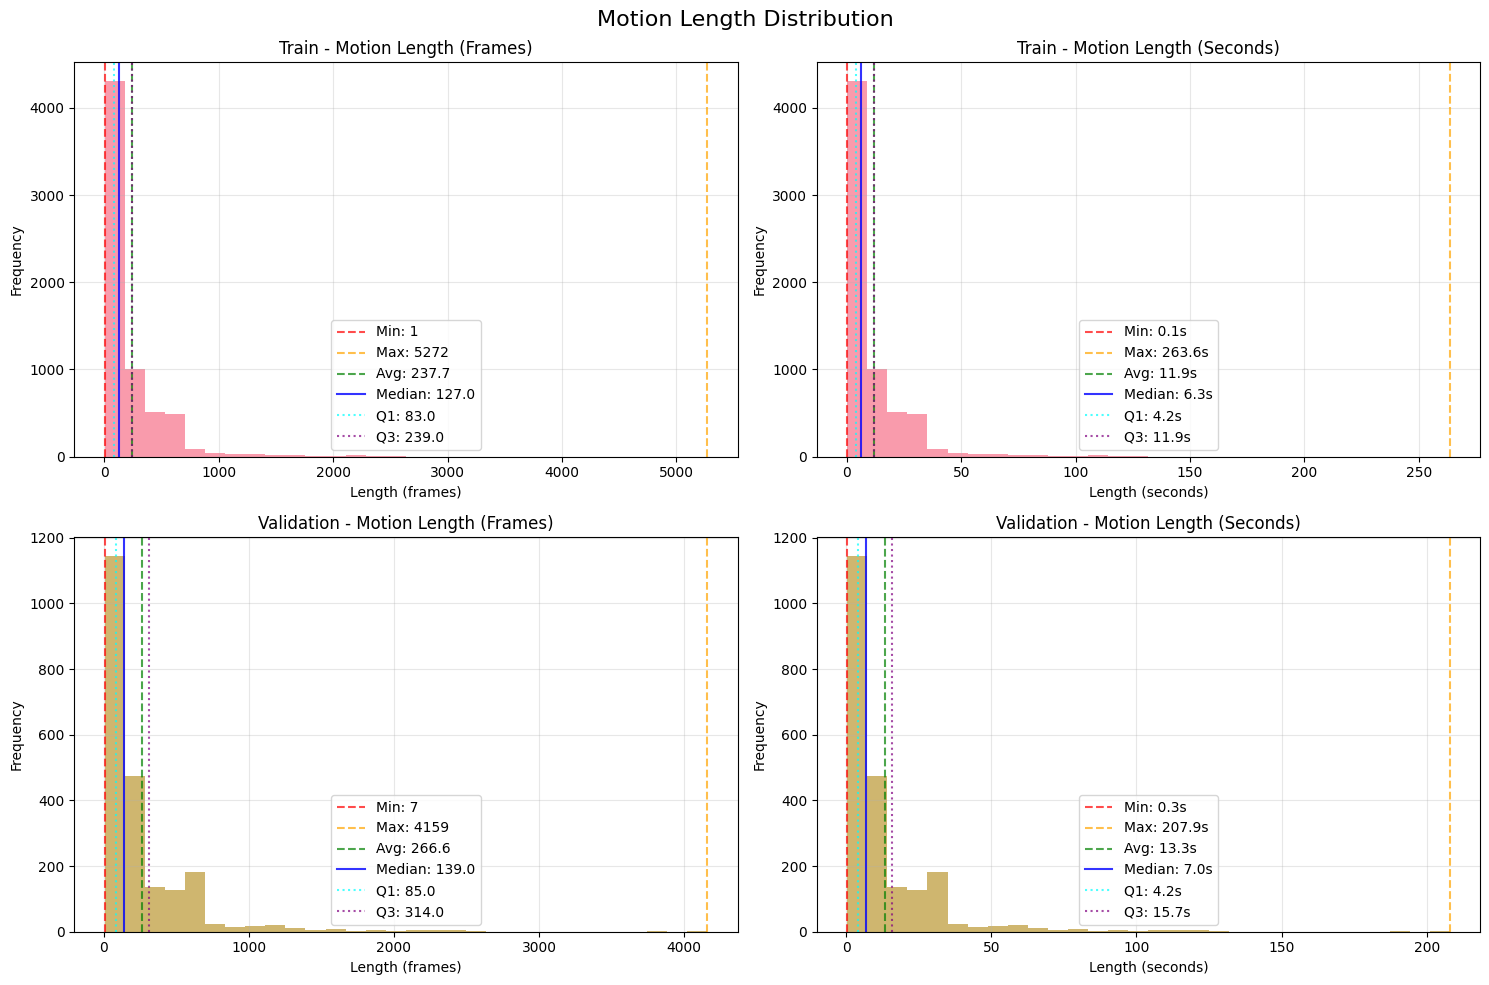

=== MOTION LENGTH STATISTICS ===

Train Dataset:
  Frames - Min: 1, Mean: 237.68, Max: 5272
  Seconds - Min: 0.05, Mean: 11.88, Max: 263.60
  75th percentile - Frames: 239.00, Seconds: 11.95
  Data loss if filtering > 10s (200 frames): 1972 samples (29.8%)
  Data loss if filtering > 15s (300 frames): 1441 samples (21.8%)
  Data loss if filtering > 20s (400 frames): 1155 samples (17.5%)
--------------------------------------------------

Validation Dataset:
  Frames - Min: 7, Mean: 266.62, Max: 4159
  Seconds - Min: 0.35, Mean: 13.33, Max: 207.95
  75th percentile - Frames: 314.00, Seconds: 15.70
  Data loss if filtering > 10s (200 frames): 739 samples (33.7%)
  Data loss if filtering > 15s (300 frames): 561 samples (25.6%)
  Data loss if filtering > 20s (400 frames): 462 samples (21.1%)
--------------------------------------------------


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Motion Length Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        # NOTE: frames distribution
        axes[i, 0].hist(lengths_frames, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Motion Length (Frames)')
        axes[i, 0].set_xlabel('Length (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        min_frames = np.min(lengths_frames)
        max_frames = np.max(lengths_frames)
        avg_frames = np.mean(lengths_frames)
        median_frames = np.median(lengths_frames)
        q1_frames = np.percentile(lengths_frames, 25)
        q3_frames = np.percentile(lengths_frames, 75)
        
        axes[i, 0].axvline(min_frames, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_frames}')
        axes[i, 0].axvline(max_frames, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_frames}')
        axes[i, 0].axvline(avg_frames, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_frames:.1f}')
        axes[i, 0].axvline(median_frames, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_frames:.1f}')
        axes[i, 0].axvline(q1_frames, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_frames:.1f}')
        axes[i, 0].axvline(q3_frames, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_frames:.1f}')
        axes[i, 0].legend()
        
        # NOTE: seconds distribution
        axes[i, 1].hist(lengths_seconds, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 1].set_title(f'{name} - Motion Length (Seconds)')
        axes[i, 1].set_xlabel('Length (seconds)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        min_seconds = np.min(lengths_seconds)
        max_seconds = np.max(lengths_seconds)
        avg_seconds = np.mean(lengths_seconds)
        median_seconds = np.median(lengths_seconds)
        q1_seconds = np.percentile(lengths_seconds, 25)
        q3_seconds = np.percentile(lengths_seconds, 75)
        
        axes[i, 1].axvline(min_seconds, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_seconds:.1f}s')
        axes[i, 1].axvline(max_seconds, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_seconds:.1f}s')
        axes[i, 1].axvline(avg_seconds, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_seconds:.1f}s')
        axes[i, 1].axvline(median_seconds, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_seconds:.1f}s')
        axes[i, 1].axvline(q1_seconds, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_seconds:.1f}s')
        axes[i, 1].axvline(q3_seconds, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_seconds:.1f}s')
        axes[i, 1].legend()

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        print(f"\n{name} Dataset:")
        print(f"  Frames - Min: {np.min(lengths_frames)}, Mean: {np.mean(lengths_frames):.2f}, Max: {np.max(lengths_frames)}")
        print(f"  Seconds - Min: {np.min(lengths_seconds):.2f}, Mean: {np.mean(lengths_seconds):.2f}, Max: {np.max(lengths_seconds):.2f}")
        print(f"  75th percentile - Frames: {np.percentile(lengths_frames, 75):.2f}, Seconds: {np.percentile(lengths_seconds, 75):.2f}")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(lengths_frames) > threshold_frames)
            loss_percentage = (filtered_count / len(lengths_frames)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

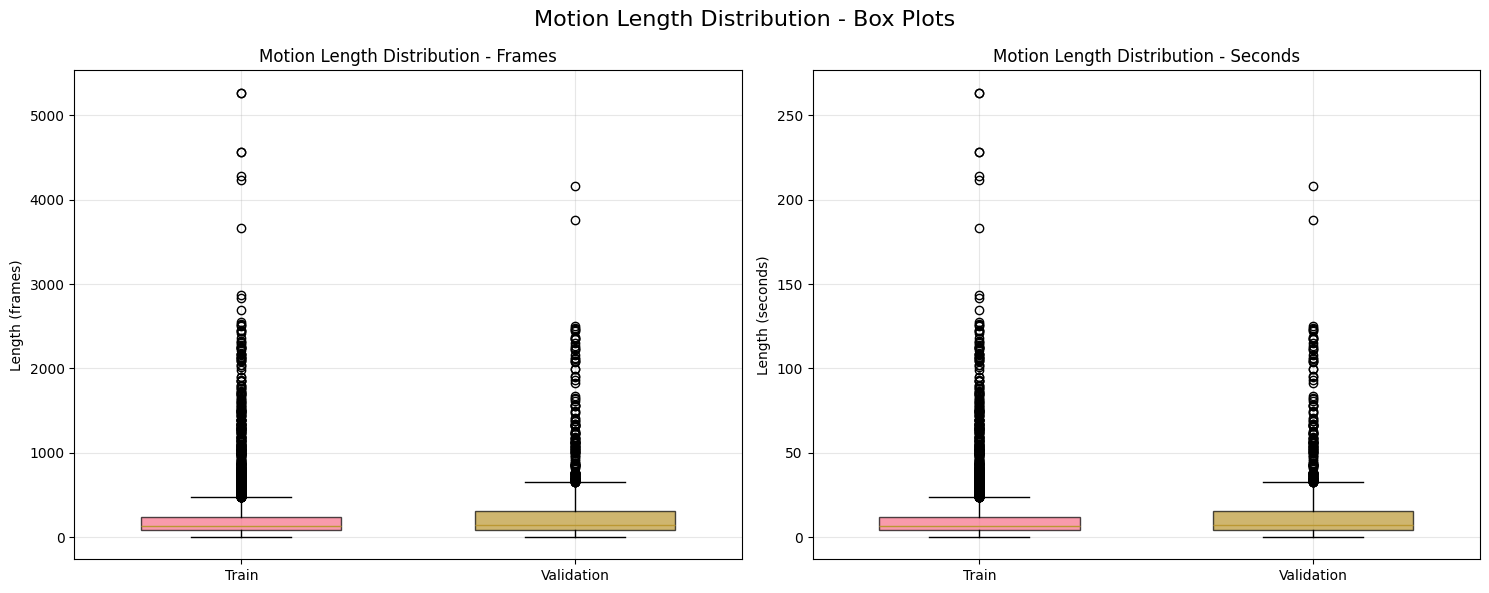

=== MOTION LENGTH FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 2s: 304 (4.6%)
  Motions < 3s: 660 (10.0%)
  Motions < 5s: 2349 (35.5%)
  Motions > 10s: 1972 (29.8%)
  Motions > 15s: 1441 (21.8%)
  Motions > 20s: 1155 (17.5%)
  Motions > 25s: 838 (12.7%)
  Keeping 3s-15s: 4514 motions (68.2% retained)
  Keeping 3s-20s: 4800 motions (72.6% retained)
  Keeping 5s-20s: 3111 motions (47.0% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 2s: 85 (3.9%)
  Motions < 3s: 197 (9.0%)
  Motions < 5s: 720 (32.8%)
  Motions > 10s: 739 (33.7%)
  Motions > 15s: 561 (25.6%)
  Motions > 20s: 462 (21.1%)
  Motions > 25s: 338 (15.4%)
  Keeping 3s-15s: 1435 motions (65.4% retained)
  Keeping 3s-20s: 1534 motions (69.9% retained)
  Keeping 5s-20s: 1011 motions (46.1% retained)
--------------------------------------------------


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Motion Length Distribution - Box Plots', fontsize=16)

datasets = ['Train', 'Validation']
for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        box_data_frames = [lengths_frames]
        bp1 = axes[0].boxplot(box_data_frames, positions=[i+1], widths=0.6, patch_artist=True)
        bp1['boxes'][0].set_facecolor(f'C{i}')
        bp1['boxes'][0].set_alpha(0.7)
        
        box_data_seconds = [lengths_seconds]
        bp2 = axes[1].boxplot(box_data_seconds, positions=[i+1], widths=0.6, patch_artist=True)
        bp2['boxes'][0].set_facecolor(f'C{i}')
        bp2['boxes'][0].set_alpha(0.7)

axes[0].set_title('Motion Length Distribution - Frames')
axes[0].set_ylabel('Length (frames)')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(datasets)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Motion Length Distribution - Seconds')
axes[1].set_ylabel('Length (seconds)')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(datasets)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_seconds:
        total_motions = len(lengths_seconds)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(lengths_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(lengths_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(lengths_seconds) < min_t) | (np.array(lengths_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Prompts per Motion Distribution**

This shows how many prompts are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

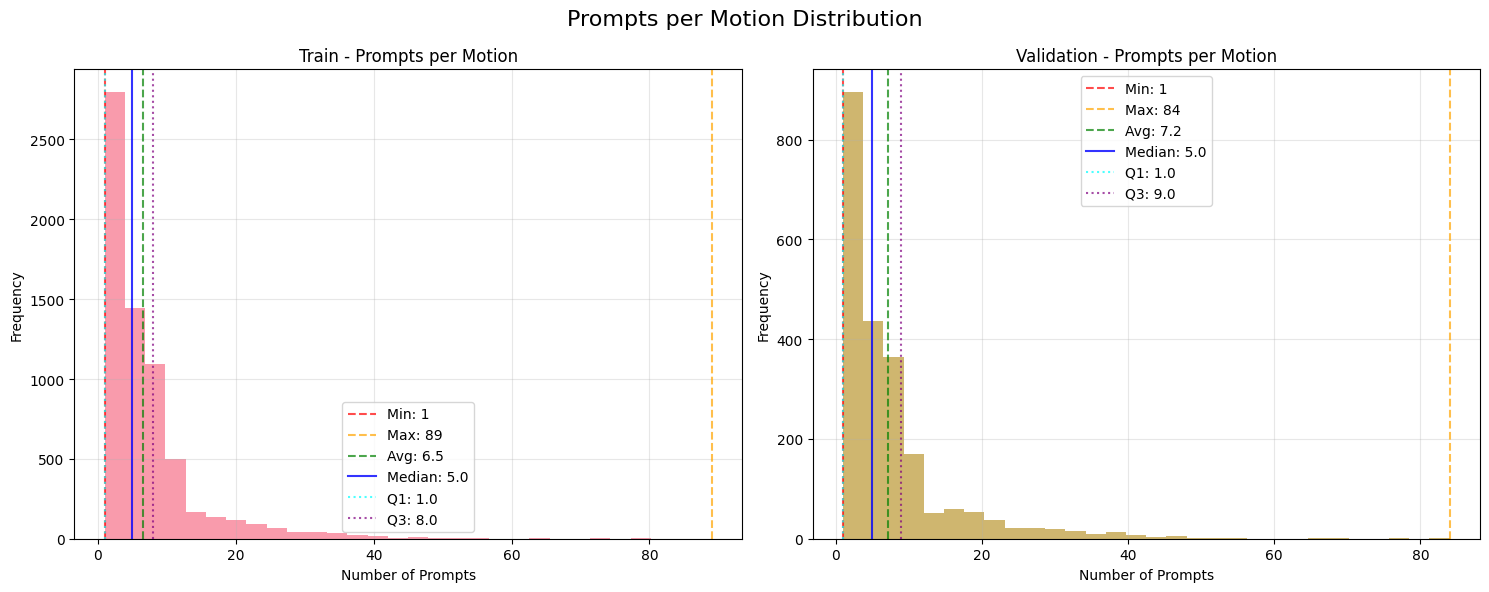

=== PROMPTS PER MOTION STATISTICS ===

Train Dataset:
  Min: 1, Mean: 6.52, Max: 89
  75th percentile: 8.00
  Data loss if filtering > 12 prompts: 779 samples (11.8%)
  Data loss if filtering > 15 prompts: 609 samples (9.2%)
  Data loss if filtering > 20 prompts: 399 samples (6.0%)
--------------------------------------------------

Validation Dataset:
  Min: 1, Mean: 7.18, Max: 84
  75th percentile: 9.00
  Data loss if filtering > 12 prompts: 326 samples (14.9%)
  Data loss if filtering > 15 prompts: 255 samples (11.6%)
  Data loss if filtering > 20 prompts: 161 samples (7.3%)
--------------------------------------------------


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        axes[i].hist(prompts_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Prompts per Motion')
        axes[i].set_xlabel('Number of Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_prompts = np.min(prompts_per_motion)
        max_prompts = np.max(prompts_per_motion)
        avg_prompts = np.mean(prompts_per_motion)
        median_prompts = np.median(prompts_per_motion)
        q1_prompts = np.percentile(prompts_per_motion, 25)
        q3_prompts = np.percentile(prompts_per_motion, 75)
        
        axes[i].axvline(min_prompts, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_prompts}')
        axes[i].axvline(max_prompts, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_prompts}')
        axes[i].axvline(avg_prompts, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_prompts:.1f}')
        axes[i].axvline(median_prompts, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_prompts:.1f}')
        axes[i].axvline(q1_prompts, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_prompts:.1f}')
        axes[i].axvline(q3_prompts, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_prompts:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(prompts_per_motion)}, Mean: {np.mean(prompts_per_motion):.2f}, Max: {np.max(prompts_per_motion)}")
        print(f"  75th percentile: {np.percentile(prompts_per_motion, 75):.2f}")
        
        for threshold in [12, 15, 20]:
            filtered_count = np.sum(np.array(prompts_per_motion) > threshold)
            loss_percentage = (filtered_count / len(prompts_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} prompts: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

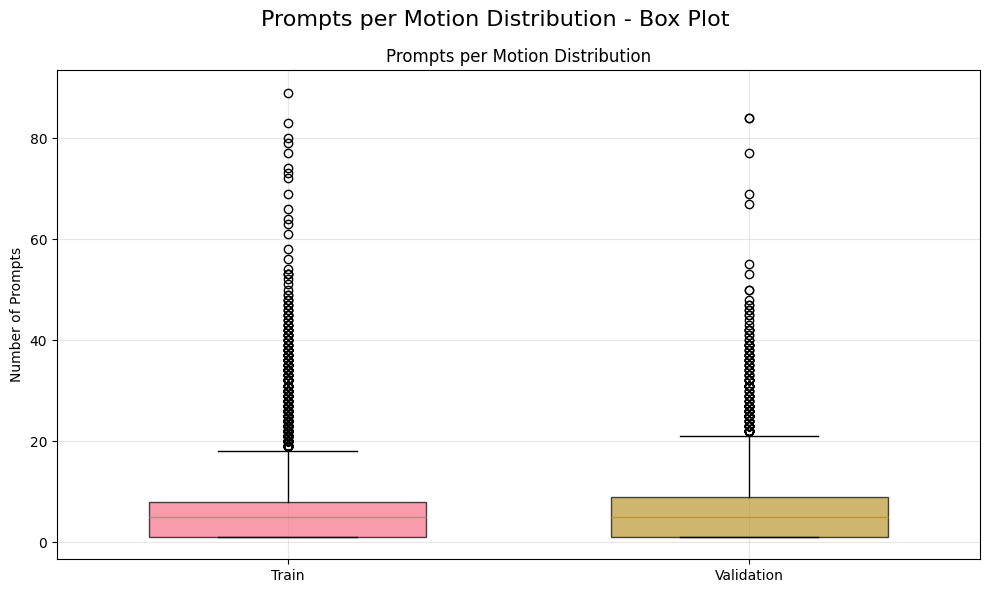

=== PROMPTS PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 2620 (39.6%)
  Motions < 3 prompts: 2660 (40.2%)
  Motions < 5 prompts: 3181 (48.1%)
  Motions > 8 prompts: 1525 (23.1%)
  Motions > 10 prompts: 1017 (15.4%)
  Motions > 12 prompts: 779 (11.8%)
  Motions > 15 prompts: 609 (9.2%)
  Motions > 20 prompts: 399 (6.0%)
  Keeping 2-8 prompts: 2470 motions (37.3% retained)
  Keeping 2-10 prompts: 2978 motions (45.0% retained)
  Keeping 3-12 prompts: 3176 motions (48.0% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 835 (38.1%)
  Motions < 3 prompts: 849 (38.7%)
  Motions < 5 prompts: 1006 (45.9%)
  Motions > 8 prompts: 573 (26.1%)
  Motions > 10 prompts: 404 (18.4%)
  Motions > 12 prompts: 326 (14.9%)
  Motions > 15 prompts: 255 (11.6%)
  Motions > 20 prompts: 161 (7.3%)
  Keeping 2-8 prompts: 785 m

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Prompts per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    prompts_per_motion = analysis['sample_prompt_counts']
    if prompts_per_motion:
        box_data.append(prompts_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Prompts per Motion Distribution')
ax.set_ylabel('Number of Prompts')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        total_motions = len(prompts_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(prompts_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} prompts: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(prompts_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} prompts: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(prompts_per_motion) < min_t) | (np.array(prompts_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} prompts: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans per Motion Distribution**

This shows how many spans (temporal segments) are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

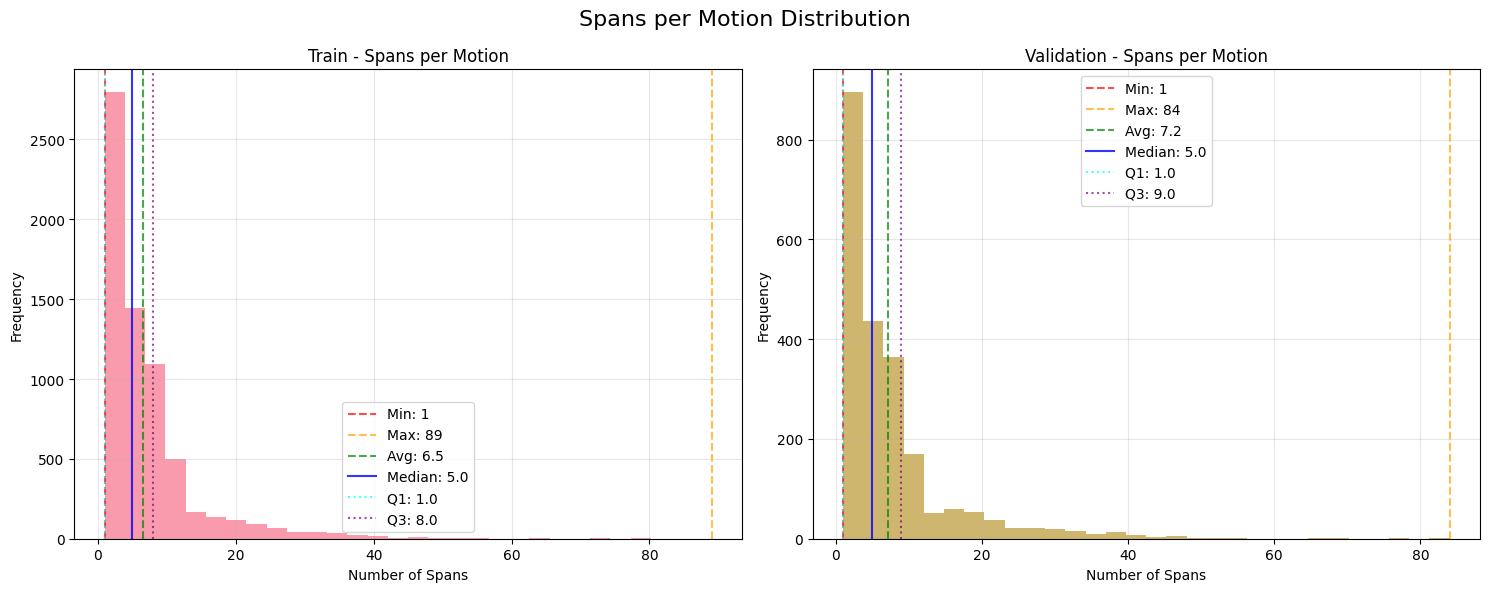

=== SPANS PER MOTION STATISTICS ===

Train Dataset:
  Min: 1, Mean: 6.52, Max: 89
  75th percentile: 8.00
  Data loss if filtering > 10 spans: 1017 samples (15.4%)
  Data loss if filtering > 15 spans: 609 samples (9.2%)
  Data loss if filtering > 20 spans: 399 samples (6.0%)
--------------------------------------------------

Validation Dataset:
  Min: 1, Mean: 7.18, Max: 84
  75th percentile: 9.00
  Data loss if filtering > 10 spans: 404 samples (18.4%)
  Data loss if filtering > 15 spans: 255 samples (11.6%)
  Data loss if filtering > 20 spans: 161 samples (7.3%)
--------------------------------------------------


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        axes[i].hist(spans_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Spans per Motion')
        axes[i].set_xlabel('Number of Spans')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_spans = np.min(spans_per_motion)
        max_spans = np.max(spans_per_motion)
        avg_spans = np.mean(spans_per_motion)
        median_spans = np.median(spans_per_motion)
        q1_spans = np.percentile(spans_per_motion, 25)
        q3_spans = np.percentile(spans_per_motion, 75)
        
        axes[i].axvline(min_spans, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_spans}')
        axes[i].axvline(max_spans, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_spans}')
        axes[i].axvline(avg_spans, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_spans:.1f}')
        axes[i].axvline(median_spans, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_spans:.1f}')
        axes[i].axvline(q1_spans, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_spans:.1f}')
        axes[i].axvline(q3_spans, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_spans:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_per_motion)}, Mean: {np.mean(spans_per_motion):.2f}, Max: {np.max(spans_per_motion)}")
        print(f"  75th percentile: {np.percentile(spans_per_motion, 75):.2f}")
        
        for threshold in [10, 15, 20]:
            filtered_count = np.sum(np.array(spans_per_motion) > threshold)
            loss_percentage = (filtered_count / len(spans_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} spans: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

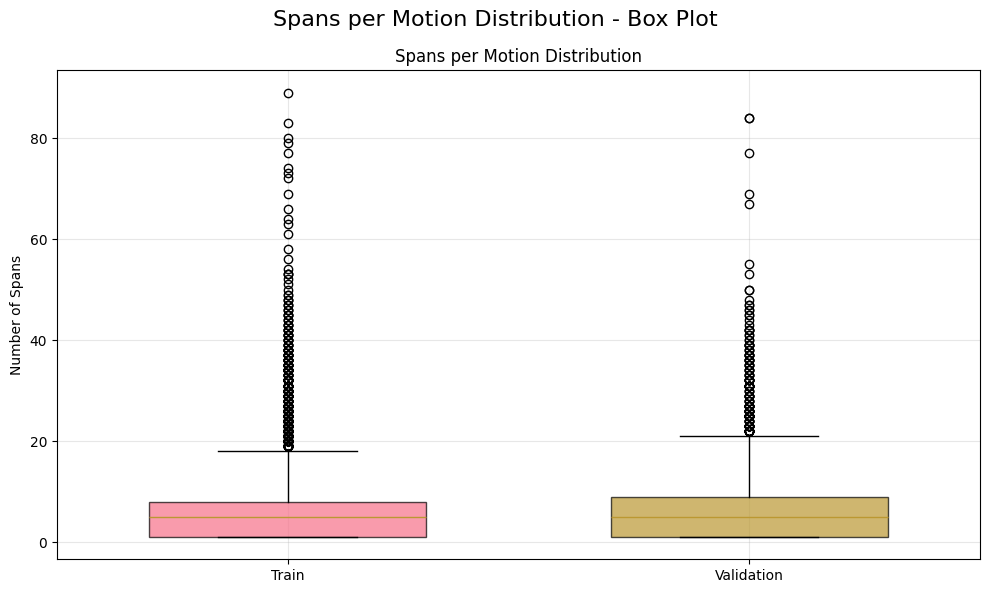

=== SPANS PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 2620 (39.6%)
  Motions < 3 spans: 2660 (40.2%)
  Motions < 5 spans: 3181 (48.1%)
  Motions > 8 spans: 1525 (23.1%)
  Motions > 10 spans: 1017 (15.4%)
  Motions > 12 spans: 779 (11.8%)
  Motions > 15 spans: 609 (9.2%)
  Motions > 20 spans: 399 (6.0%)
  Keeping 2-8 spans: 2470 motions (37.3% retained)
  Keeping 2-10 spans: 2978 motions (45.0% retained)
  Keeping 3-12 spans: 3176 motions (48.0% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 835 (38.1%)
  Motions < 3 spans: 849 (38.7%)
  Motions < 5 spans: 1006 (45.9%)
  Motions > 8 spans: 573 (26.1%)
  Motions > 10 spans: 404 (18.4%)
  Motions > 12 spans: 326 (14.9%)
  Motions > 15 spans: 255 (11.6%)
  Motions > 20 spans: 161 (7.3%)
  Keeping 2-8 spans: 785 motions (35.8% retained)
  Keeping 2-10 spans: 

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_per_motion = analysis['spans_per_motion']
    if spans_per_motion:
        box_data.append(spans_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans per Motion Distribution')
ax.set_ylabel('Number of Spans')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        total_motions = len(spans_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(spans_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(spans_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(spans_per_motion) < min_t) | (np.array(spans_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans Duration Distribution**

This shows the distribution of individual span durations in frames, with horizontal lines indicating minimum, maximum, and average values.

</div>

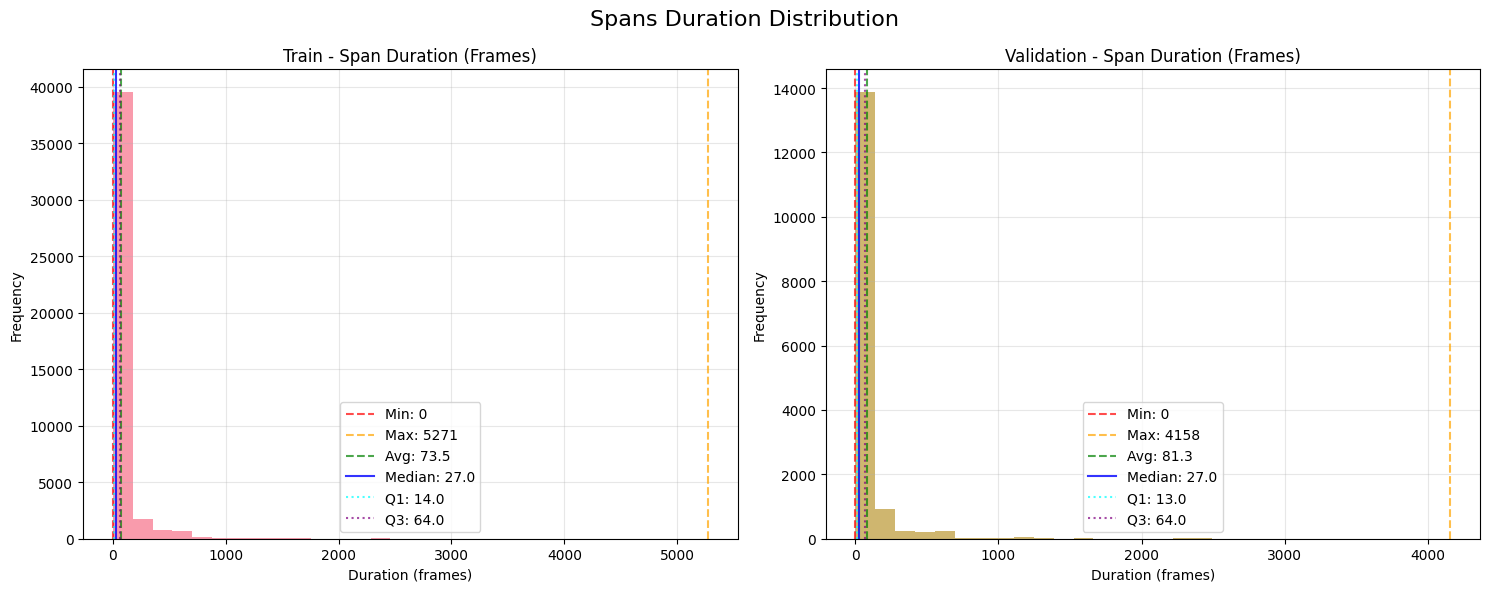

=== SPANS DURATION STATISTICS ===

Train Dataset:
  Min: 0 frames (0.00s)
  Mean: 73.47 frames (3.67s)
  Max: 5271 frames (263.55s)
  75th percentile: 64.00 frames (3.20s)
  Data loss if filtering > 3s (60 frames): 11346 spans (26.3%)
  Data loss if filtering > 5s (100 frames): 6896 spans (16.0%)
  Data loss if filtering > 8s (160 frames): 3975 spans (9.2%)
--------------------------------------------------

Validation Dataset:
  Min: 0 frames (0.00s)
  Mean: 81.31 frames (4.07s)
  Max: 4158 frames (207.90s)
  75th percentile: 64.00 frames (3.20s)
  Data loss if filtering > 3s (60 frames): 4117 spans (26.2%)
  Data loss if filtering > 5s (100 frames): 2587 spans (16.4%)
  Data loss if filtering > 8s (160 frames): 1566 spans (9.9%)
--------------------------------------------------


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans Duration Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        axes[i].hist(span_durations, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Span Duration (Frames)')
        axes[i].set_xlabel('Duration (frames)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(span_durations)
        max_duration = np.max(span_durations)
        avg_duration = np.mean(span_durations)
        median_duration = np.median(span_durations)
        q1_duration = np.percentile(span_durations, 25)
        q3_duration = np.percentile(span_durations, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS DURATION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(span_durations)} frames ({np.min(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(span_durations):.2f} frames ({np.mean(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(span_durations)} frames ({np.max(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(span_durations, 75):.2f} frames ({np.percentile(span_durations, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [3, 5, 8]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(span_durations) > threshold_frames)
            loss_percentage = (filtered_count / len(span_durations)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} spans ({loss_percentage:.1f}%)")
    print("-" * 50)

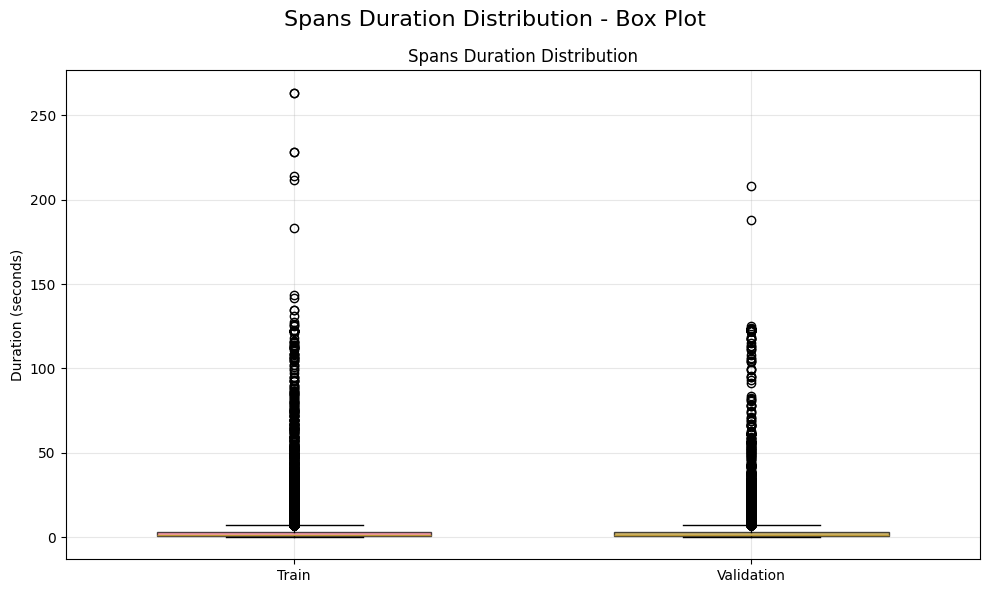

=== SPANS DURATION FILTERING ANALYSIS ===

Train Dataset (43119 total spans):
  Spans < 0.5s: 6791 (15.7%)
  Spans < 1.0s: 15820 (36.7%)
  Spans < 1.5s: 23053 (53.5%)
  Spans < 2.0s: 27241 (63.2%)
  Spans > 3s: 11346 (26.3%)
  Spans > 5s: 6896 (16.0%)
  Spans > 8s: 3975 (9.2%)
  Spans > 10s: 2966 (6.9%)
  Keeping 1.0s-5s: 20403 spans (47.3% retained)
  Keeping 1.0s-8s: 23324 spans (54.1% retained)
  Keeping 1.5s-8s: 16091 spans (37.3% retained)
--------------------------------------------------

Validation Dataset (15740 total spans):
  Spans < 0.5s: 2575 (16.4%)
  Spans < 1.0s: 5917 (37.6%)
  Spans < 1.5s: 8483 (53.9%)
  Spans < 2.0s: 10000 (63.5%)
  Spans > 3s: 4117 (26.2%)
  Spans > 5s: 2587 (16.4%)
  Spans > 8s: 1566 (9.9%)
  Spans > 10s: 1211 (7.7%)
  Keeping 1.0s-5s: 7236 spans (46.0% retained)
  Keeping 1.0s-8s: 8257 spans (52.5% retained)
  Keeping 1.5s-8s: 5691 spans (36.2% retained)
--------------------------------------------------


In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans Duration Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    span_durations = analysis['durations']
    if span_durations:
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        box_data.append(span_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans Duration Distribution')
ax.set_ylabel('Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS DURATION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        total_spans = len(span_durations)
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        print(f"\n{name} Dataset ({total_spans} total spans):")
        
        for min_threshold in [0.5, 1.0, 1.5, 2.0]:
            filtered_min = np.sum(np.array(span_durations_seconds) < min_threshold)
            print(f"  Spans < {min_threshold}s: {filtered_min} ({filtered_min/total_spans*100:.1f}%)")
            
        for max_threshold in [3, 5, 8, 10]:
            filtered_max = np.sum(np.array(span_durations_seconds) > max_threshold)
            print(f"  Spans > {max_threshold}s: {filtered_max} ({filtered_max/total_spans*100:.1f}%)")
            
        for min_t, max_t in [(1.0, 5), (1.0, 8), (1.5, 8)]:
            filtered_both = np.sum((np.array(span_durations_seconds) < min_t) | (np.array(span_durations_seconds) > max_t))
            remaining = total_spans - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} spans ({remaining/total_spans*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Total Spans per Motion (Per Motion Analysis)**

This shows the total span duration per motion sequence, indicating how much of each motion is covered by annotated spans.

</div>

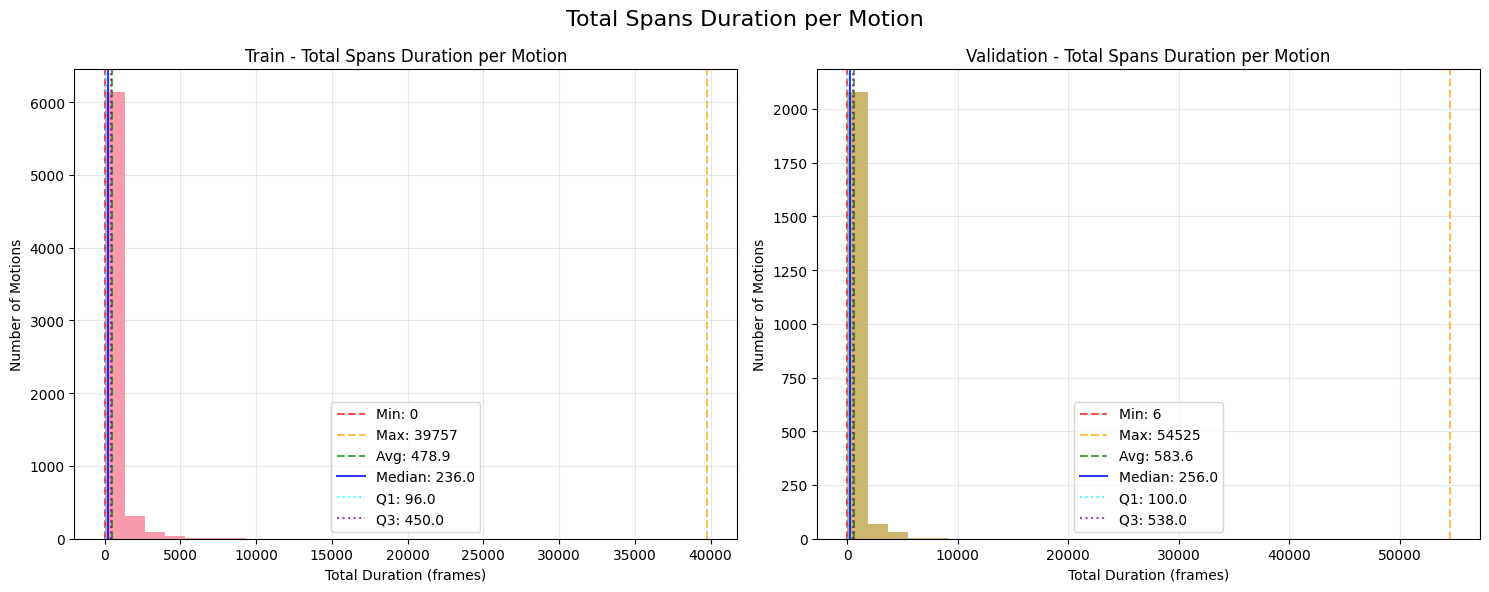

=== TOTAL SPANS DURATION PER MOTION STATISTICS ===

Train Dataset:
  Min: 0 frames (0.00s)
  Mean: 478.92 frames (23.95s)
  Max: 39757 frames (1987.85s)
  75th percentile: 450.00 frames (22.50s)
  Data loss if filtering > 10s total spans (200 frames): 3707 motions (56.0%)
  Data loss if filtering > 15s total spans (300 frames): 2671 motions (40.4%)
  Data loss if filtering > 20s total spans (400 frames): 1918 motions (29.0%)
--------------------------------------------------

Validation Dataset:
  Min: 6 frames (0.30s)
  Mean: 583.60 frames (29.18s)
  Max: 54525 frames (2726.25s)
  75th percentile: 538.00 frames (26.90s)
  Data loss if filtering > 10s total spans (200 frames): 1293 motions (59.0%)
  Data loss if filtering > 15s total spans (300 frames): 962 motions (43.9%)
  Data loss if filtering > 20s total spans (400 frames): 733 motions (33.4%)
--------------------------------------------------


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Total Spans Duration per Motion', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        axes[i].hist(spans_durations_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Total Spans Duration per Motion')
        axes[i].set_xlabel('Total Duration (frames)')
        axes[i].set_ylabel('Number of Motions')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(spans_durations_per_motion)
        max_duration = np.max(spans_durations_per_motion)
        avg_duration = np.mean(spans_durations_per_motion)
        median_duration = np.median(spans_durations_per_motion)
        q1_duration = np.percentile(spans_durations_per_motion, 25)
        q3_duration = np.percentile(spans_durations_per_motion, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(median_duration, color='blue', linestyle='-', alpha=0.8, label=f'Median: {median_duration:.1f}')
        axes[i].axvline(q1_duration, color='cyan', linestyle=':', alpha=0.7, label=f'Q1: {q1_duration:.1f}')
        axes[i].axvline(q3_duration, color='purple', linestyle=':', alpha=0.7, label=f'Q3: {q3_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_durations_per_motion)} frames ({np.min(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(spans_durations_per_motion):.2f} frames ({np.mean(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(spans_durations_per_motion)} frames ({np.max(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(spans_durations_per_motion, 75):.2f} frames ({np.percentile(spans_durations_per_motion, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(spans_durations_per_motion) > threshold_frames)
            loss_percentage = (filtered_count / len(spans_durations_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s total spans ({threshold_frames} frames): {filtered_count} motions ({loss_percentage:.1f}%)")
    print("-" * 50)

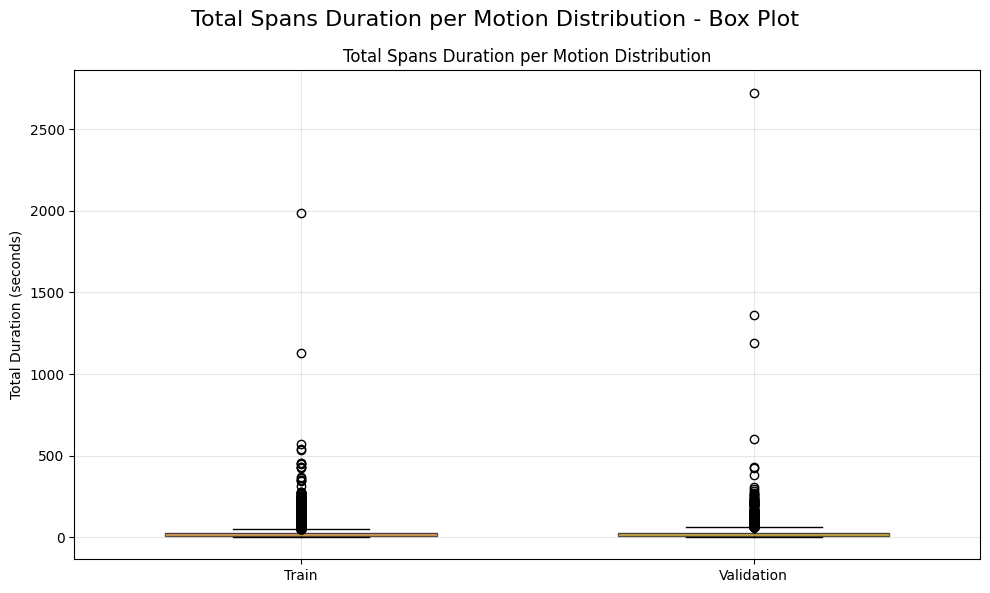

=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===

Train Dataset (6615 total motions):
  Motions < 2s total spans: 298 (4.5%)
  Motions < 3s total spans: 603 (9.1%)
  Motions < 5s total spans: 1741 (26.3%)
  Motions > 10s total spans: 3707 (56.0%)
  Motions > 15s total spans: 2671 (40.4%)
  Motions > 20s total spans: 1918 (29.0%)
  Motions > 25s total spans: 1461 (22.1%)
  Keeping 3s-15s total spans: 3341 motions (50.5% retained)
  Keeping 3s-20s total spans: 4094 motions (61.9% retained)
  Keeping 5s-20s total spans: 2956 motions (44.7% retained)
--------------------------------------------------

Validation Dataset (2193 total motions):
  Motions < 2s total spans: 79 (3.6%)
  Motions < 3s total spans: 175 (8.0%)
  Motions < 5s total spans: 543 (24.8%)
  Motions > 10s total spans: 1293 (59.0%)
  Motions > 15s total spans: 962 (43.9%)
  Motions > 20s total spans: 733 (33.4%)
  Motions > 25s total spans: 581 (26.5%)
  Keeping 3s-15s total spans: 1056 motions (48.2% retained)
  

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Total Spans Duration per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    if spans_durations_per_motion:
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        box_data.append(spans_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Total Spans Duration per Motion Distribution')
ax.set_ylabel('Total Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        total_motions = len(spans_durations_per_motion)
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(spans_durations_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s total spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(spans_durations_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s total spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(spans_durations_seconds) < min_t) | (np.array(spans_durations_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s total spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)